In [3]:
# 셀 1: 프로젝트 루트 / 데이터셋 / 결과 폴더 설정 (VR 노트북과 동일 스타일)

from pathlib import Path
import os
import cv2
import mediapipe as mp
import numpy as np
from collections import defaultdict
import random
import glob
from tqdm import tqdm

# 현재 노트북이 위치한 Code 폴더 기준
CODE_DIR = Path.cwd()
PROJECT_DIR = CODE_DIR.parent          # .../원대한_...
DIP_ROOT = PROJECT_DIR.parent          # .../DIP
DATASET_ROOT = DIP_ROOT / "dataset"    # DIP/dataset

# CV tesk1 결과 저장 루트 (RGB/IR 공용)
RESULTS_RGBIR_DIR = CODE_DIR / "results_rgbir"
RESULTS_RGBIR_DIR.mkdir(parents=True, exist_ok=True)

print("CODE_DIR       :", CODE_DIR)
print("PROJECT_DIR    :", PROJECT_DIR)
print("DIP_ROOT       :", DIP_ROOT)
print("DATASET_ROOT   :", DATASET_ROOT)
print("RESULTS_RGBIR_DIR:", RESULTS_RGBIR_DIR)


CODE_DIR       : c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code
PROJECT_DIR    : c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS
DIP_ROOT       : c:\Users\CONSOMMES\Downloads\DIP
DATASET_ROOT   : c:\Users\CONSOMMES\Downloads\DIP\dataset
RESULTS_RGBIR_DIR: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_rgbir


In [4]:
import cv2
import mediapipe as mp
import numpy as np
import os
import glob
import random
import shutil
from collections import defaultdict
from tqdm import tqdm

# ==========================================
# 1. 파라미터 설정 (확정된 값)
# ==========================================
INPUT_ROOT = str(DATASET_ROOT)
OUTPUT_ROOT = str(RESULTS_RGBIR_DIR)

SUBJECTS = ['s01', 's02', 's03', 's04', 't01', 't02']

# [타겟 조건: IR 30, 50만 변경]
TARGET_MOD = 'IR'
TARGET_CONDS = ['30', '50']

# [알고리즘 파라미터]
MORPH_KERNEL_SIZE = 3
CANNY_MIN = 40
CANNY_MAX = 80
VALID_THRESH = 120
VALID_ERODE_SIZE = 1
USE_HIST_EQ = False

# [로직 제어 변수]
REMOVE_BOTTOM_RATIO = 0.35     # 엣지 하단 35% 제거
REMOVE_BOTTOM_BLOB = True      # 물체 제거 로직 ON

# [Safe Zone 설정 (좌상단 & 우상단만 안전)]
SAFE_Y_RATIO = 0.50            # 상단 50%
SAFE_X_MIN_RATIO = 0.30        # 좌측 30%
SAFE_X_MAX_RATIO = 0.70        # 우측 70% (우측 30% 영역)

# [기타 설정]
MIN_LENGTH = 40
TARGET_VOTES = 4
MAX_ATTEMPTS = 200
MIN_RADIUS_PIXEL = 8
MAX_RADIUS_PIXEL = 13

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# ==========================================
# 2. 알고리즘 함수
# ==========================================
def get_circle_from_3_points(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    if abs(D) < 1e-5: return None
    cx = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    cy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    radius = np.sqrt((x1 - cx)**2 + (y1 - cy)**2)
    return (cx, cy, radius)

def solve_and_draw_smart(points_y, points_x, region_w, region_h, offset_x, validation_mask):
    if len(points_x) < 3: return None
    points = list(zip(points_x, points_y))
    vote_box = defaultdict(int)
    h_mask, w_mask = validation_mask.shape

    # 1. 투표 루프
    for i in range(MAX_ATTEMPTS):
        try:
            samples = random.sample(points, 3)
        except ValueError: break
        res = get_circle_from_3_points(samples[0], samples[1], samples[2])
        if res:
            cx, cy, r = res
            if MIN_RADIUS_PIXEL <= r <= MAX_RADIUS_PIXEL:
                if 0 <= cx <= region_w and 0 <= cy <= region_h:
                    cand = (int(round(cx)), int(round(cy)), int(round(r)))
                    vote_box[cand] += 1
                    # Early Exit
                    if vote_box[cand] >= TARGET_VOTES:
                        check_x = cand[0] + offset_x
                        check_y = cand[1]
                        if 0 <= check_x < w_mask and 0 <= check_y < h_mask:
                            if validation_mask[check_y, check_x] != 255: # 검은색(유효)
                                return (check_x, check_y, cand[2])

    # 2. Fallback
    if not vote_box: return None
    sorted_candidates = sorted(vote_box.items(), key=lambda item: item[1], reverse=True)
    for cand, count in sorted_candidates:
        cx_local, cy_local, r = cand
        check_x = cx_local + offset_x
        check_y = cy_local
        if 0 <= check_x < w_mask and 0 <= check_y < h_mask:
            if validation_mask[check_y, check_x] != 255:
                return (check_x, check_y, r)
    return None

def process_and_save_final(image_path):
    if not os.path.exists(image_path): return None

    # 1. 이미지 로드
    img_origin = cv2.imread(image_path)
    if img_origin is None: return None

    img_draw = img_origin.copy() # 원본 위에 그림

    # [전처리] HistEq OFF
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)

    # [얼굴 검출]
    results = face_detection.process(img_rgb)
    if not results.detections: return None

    detection = results.detections[0]
    bbox = detection.location_data.relative_bounding_box
    h_orig, w_orig, _ = img_rgb.shape

    face_x = max(0, int(bbox.xmin * w_orig))
    face_y = max(0, int(bbox.ymin * h_orig))
    face_w = int(bbox.width * w_orig)
    face_h = int(bbox.height * h_orig)

    face_crop = img_rgb[face_y:face_y+face_h, face_x:face_x+face_w]

    # [ROI]
    h_face, w_face, _ = face_crop.shape
    roi_y_start = int(h_face * 0.2)
    roi_y_end = int(h_face * 0.5)
    roi_x_start = int(w_face * 0.2)
    roi_x_end = int(w_face * 0.8)

    roi_rgb = face_crop[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
    roi_hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV)
    _, _, roi_v = cv2.split(roi_hsv)

    # [Morphology] (Kernel Size 적용)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_KERNEL_SIZE, MORPH_KERNEL_SIZE))
    roi_erode = cv2.erode(roi_v, kernel, iterations=1)
    roi_morph = cv2.dilate(roi_erode, kernel, iterations=1)
    roi_blur = cv2.GaussianBlur(roi_morph, (3, 3), 0)

    # [Valid Mask] (Thresh, Erode 적용)
    _, val_thresh = cv2.threshold(roi_morph, VALID_THRESH, 255, cv2.THRESH_BINARY)
    val_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (VALID_ERODE_SIZE, VALID_ERODE_SIZE))
    validation_mask = cv2.erode(val_thresh, val_kernel, iterations=1)

    # ========================================================
    # [NEW] 하단 검은 물체 제거 (Safe Zone 적용)
    # ========================================================
    if REMOVE_BOTTOM_BLOB:
        inv_mask = cv2.bitwise_not(validation_mask)
        contours, _ = cv2.findContours(inv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) >= 1:
            cnts_sorted = sorted(contours, key=lambda c: np.max(c[:, 0, 1]), reverse=True)
            bottom_cnt = cnts_sorted[0]

            single_blob_mask = np.zeros_like(validation_mask)
            cv2.drawContours(single_blob_mask, [bottom_cnt], -1, 255, -1)

            # Safe Zone 기준
            h_mask, w_mask = validation_mask.shape
            safe_y = int(h_mask * SAFE_Y_RATIO)
            safe_x_left = int(w_mask * SAFE_X_MIN_RATIO)
            safe_x_right = int(w_mask * SAFE_X_MAX_RATIO)

            # Danger Zone 정의 (중앙 하단)
            y_indices, x_indices = np.indices(validation_mask.shape)

            # Safe Zone: Top OR Left OR Right
            is_top = y_indices < safe_y
            is_left = x_indices < safe_x_left
            is_right = x_indices > safe_x_right
            is_safe = is_top | is_left | is_right

            is_danger = ~is_safe

            # 제거
            pixels_to_remove = (single_blob_mask == 255) & is_danger
            validation_mask[pixels_to_remove] = 255
    # ========================================================

    # [Edges] (Canny 적용)
    edges_raw = cv2.Canny(roi_blur, CANNY_MIN, CANNY_MAX)
    contours, _ = cv2.findContours(edges_raw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    edges_filtered = np.zeros_like(edges_raw)
    for cnt in contours:
        if cv2.arcLength(cnt, False) > MIN_LENGTH:
            cv2.drawContours(edges_filtered, [cnt], -1, 255, 1)

    # [Bottom Edge Cut]
    h_roi, w_roi = edges_filtered.shape
    bottom_cut_y = int(h_roi * (1 - REMOVE_BOTTOM_RATIO))
    edges_filtered[bottom_cut_y:, :] = 0

    # [Top Edge Removal]
    if True: # 변수화 가능하지만 일단 ON
        valid_contours_after_cut, _ = cv2.findContours(edges_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(valid_contours_after_cut) >= 4:
            cnt_with_min_y = []
            for cnt in valid_contours_after_cut:
                min_y = np.min(cnt[:, 0, 1])
                cnt_with_min_y.append((cnt, min_y))
            cnt_with_min_y.sort(key=lambda x: x[1])
            for i in range(2):
                cnt_to_remove = cnt_with_min_y[i][0]
                cv2.drawContours(edges_filtered, [cnt_to_remove], -1, 0, 2)

    # [Voting]
    h_roi, w_roi = edges_filtered.shape
    mid_x = w_roi // 2
    offset_global_x = face_x + roi_x_start
    offset_global_y = face_y + roi_y_start

    ly, lx = np.where(edges_filtered[:, :mid_x] == 255)
    l_res = solve_and_draw_smart(ly, lx, mid_x, h_roi, 0, validation_mask)

    ry, rx = np.where(edges_filtered[:, mid_x:] == 255)
    r_res = solve_and_draw_smart(ry, rx, (w_roi-mid_x), h_roi, mid_x, validation_mask)

    if l_res:
        g_cx, g_cy = offset_global_x + l_res[0], offset_global_y + l_res[1]
        cv2.circle(img_draw, (g_cx, g_cy), l_res[2], (255, 0, 0), 2)
        cv2.circle(img_draw, (g_cx, g_cy), 2, (0, 255, 255), -1)

    if r_res:
        g_cx, g_cy = offset_global_x + r_res[0], offset_global_y + r_res[1]
        cv2.circle(img_draw, (g_cx, g_cy), r_res[2], (255, 0, 0), 2)
        cv2.circle(img_draw, (g_cx, g_cy), 2, (0, 255, 255), -1)

    return img_draw

# ==========================================
# 3. 배치 실행
# ==========================================
print(f"======= Selective Update: IR 30, 50 (Advanced Masking) =======")
print(f"Params: Canny={CANNY_MIN}/{CANNY_MAX}, SafeZone=Top/Corners")

total_updated = 0

for subj in SUBJECTS:
    for cond in TARGET_CONDS: # ['30', '50']

        # 경로 생성: s01/30/IR
        input_dir = os.path.join(INPUT_ROOT, subj, cond, TARGET_MOD)
        output_dir = os.path.join(OUTPUT_ROOT, subj, cond, TARGET_MOD)

        if not os.path.exists(input_dir):
            continue

        # 출력 폴더는 이미 존재해야 함 (기존 RGB 결과 등 보존을 위해)
        # 만약 없다면 생성
        os.makedirs(output_dir, exist_ok=True)

        image_files = sorted(glob.glob(os.path.join(input_dir, '*.jpg')) +
                             glob.glob(os.path.join(input_dir, '*.png')))

        if not image_files:
            continue

        print(f"Updating: {subj}/{cond}/{TARGET_MOD} ... ({len(image_files)} images)")

        for img_path in tqdm(image_files, leave=False):
            try:
                final_img = process_and_save_final(img_path)

                if final_img is not None:
                    file_name = os.path.basename(img_path)
                    save_path = os.path.join(output_dir, file_name)
                    cv2.imwrite(save_path, final_img) # 덮어쓰기
                    total_updated += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("\n==========================================")
print(f"Selective Update Complete.")
print(f"Total Images Updated: {total_updated}")
print("==========================================")
#cat2 ir 결과.

======= Selective Update: IR 30, 50 (Advanced Masking) =======
Params: Canny=40/80, SafeZone=Top/Corners
Updating: s01/30/IR ... (216 images)


Updating: s01/50/IR ... (216 images)


Updating: s02/30/IR ... (216 images)


Updating: s02/50/IR ... (216 images)


Updating: s03/30/IR ... (216 images)


Updating: s03/50/IR ... (216 images)


Updating: s04/30/IR ... (216 images)


Updating: s04/50/IR ... (216 images)


Updating: t01/30/IR ... (216 images)


Updating: t01/50/IR ... (216 images)


Updating: t02/30/IR ... (216 images)


Updating: t02/50/IR ... (216 images)



Selective Update Complete.
Total Images Updated: 2434


In [5]:
# 셀 3: 한 장 처리 (RGB/IR 공용) - cv_tesk1_RGB,IR.ipynb의 process_and_save_final 그대로 이식

def process_and_save_final(image_path, valid_erode_size):
    """
    한 장의 RGB 또는 IR 이미지를 받아
    - 얼굴 검출
    - 눈 띠(ROI) 추출
    - 안광 제거 + 엣지 추출
    - RANSAC-like 원 추정 + validation
    을 수행하고, pupil 중심/반지름을 그림에 오버레이한 이미지를 반환.
    """
    if not os.path.exists(image_path):
        return None

    img_origin = cv2.imread(str(image_path))
    if img_origin is None:
        return None

    img_draw = img_origin.copy()
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)

    # 1. 얼굴 검출 (Mediapipe)
    results = face_detection.process(img_rgb)
    if not results.detections:
        return None

    detection = results.detections[0]
    bbox = detection.location_data.relative_bounding_box
    h_orig, w_orig, _ = img_rgb.shape

    face_x = max(0, int(bbox.xmin * w_orig))
    face_y = max(0, int(bbox.ymin * h_orig))
    face_w = int(bbox.width * w_orig)
    face_h = int(bbox.height * h_orig)

    face_crop = img_rgb[face_y:face_y+face_h, face_x:face_x+face_w]

    # 2. 눈 띠 ROI (상단 20% ~ 50%, 좌우 20%~80%)
    h_face, w_face, _ = face_crop.shape
    roi_y_start = int(h_face * 0.2)
    roi_y_end   = int(h_face * 0.5)
    roi_x_start = int(w_face * 0.2)
    roi_x_end   = int(w_face * 0.8)

    roi_rgb = face_crop[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
    roi_hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV)
    _, _, roi_v = cv2.split(roi_hsv)

    # 3. 모폴로지로 하이라이트(안광) 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                       (MORPH_KERNEL_SIZE, MORPH_KERNEL_SIZE))
    roi_erode = cv2.erode(roi_v, kernel, iterations=1)
    roi_morph = cv2.dilate(roi_erode, kernel, iterations=1)
    roi_blur  = cv2.GaussianBlur(roi_morph, (3, 3), 0)

    # 4. validation mask (너무 밝은 영역 제외)
    _, val_thresh = cv2.threshold(roi_morph, VALID_THRESH, 255, cv2.THRESH_BINARY)
    val_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                           (valid_erode_size, valid_erode_size))
    validation_mask = cv2.erode(val_thresh, val_kernel, iterations=1)

    # 5. 엣지 검출 + 컨투어 필터링
    edges_raw = cv2.Canny(roi_blur, CANNY_MIN, CANNY_MAX)
    contours, _ = cv2.findContours(edges_raw,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    edges_filtered = np.zeros_like(edges_raw)
    valid_contours = []

    # 1차 필터링: 너무 짧은 contour 제거
    for cnt in contours:
        if cv2.arcLength(cnt, False) > MIN_LENGTH:
            valid_contours.append(cnt)
            cv2.drawContours(edges_filtered, [cnt], -1, 255, 1)

    # 2차 필터링: ROI 상단부 두 개 제거 (노이즈/눈썹 등)
    if len(valid_contours) >= 4:
        cnt_with_min_y = []
        for cnt in valid_contours:
            min_y = np.min(cnt[:, 0, 1])
            cnt_with_min_y.append((cnt, min_y))
        cnt_with_min_y.sort(key=lambda x: x[1])
        for i in range(2):
            cnt_to_remove = cnt_with_min_y[i][0]
            cv2.drawContours(edges_filtered, [cnt_to_remove], -1, 0, 2)

    h_roi, w_roi = edges_filtered.shape
    mid_x = w_roi // 2

    offset_global_x = face_x + roi_x_start
    offset_global_y = face_y + roi_y_start

    # 좌/우 눈으로 분리
    ly, lx = np.where(edges_filtered[:, :mid_x] == 255)
    l_res = solve_and_draw_smart(ly, lx, mid_x, h_roi, 0, validation_mask)

    ry, rx = np.where(edges_filtered[:, mid_x:] == 255)
    r_res = solve_and_draw_smart(ry, rx, (w_roi - mid_x), h_roi, mid_x, validation_mask)

    # 6. 결과 그리기 (img_draw는 BGR)
    if l_res:
        g_cx = offset_global_x + l_res[0]
        g_cy = offset_global_y + l_res[1]
        cv2.circle(img_draw, (g_cx, g_cy), l_res[2], (255, 0, 0), 2)
        cv2.circle(img_draw, (g_cx, g_cy), 2, (0, 255, 255), -1)

    if r_res:
        g_cx = offset_global_x + r_res[0]
        g_cy = offset_global_y + r_res[1]
        cv2.circle(img_draw, (g_cx, g_cy), r_res[2], (255, 0, 0), 2)
        cv2.circle(img_draw, (g_cx, g_cy), 2, (0, 255, 255), -1)

    return img_draw


In [6]:
# 셀 4: RGB / IR 배치 실행 루프
#  - 첫 번째 노트북의 INPUT_ROOT / OUTPUT_ROOT 구조를
#    VR 노트북과 동일하게 Path 기반으로만 바꾼 버전

SUBJECTS = ['s01', 's02', 's03', 's04', 't01', 't02']
TARGET_CONDS = ['30', '50']       # 거리
TARGET_MODS  = ['RGB', 'IR']      # 모드

# valid_erode_size를 조건별로 조정하고 싶으면 여기서 설정
# (예: 50cm RGB는 2, 나머지는 5 등 – 원래 노트북 설정 반영)
ERODE_CONFIG = {
    ('RGB', '50'): 2,   # cv_tesk1에서 최종으로 쓰던 값
    ('RGB', '30'): 5,
    ('IR',  '30'): 5,
    ('IR',  '50'): 5,
}

def run_batch_rgb_ir():
    total_processed = 0

    for mod in TARGET_MODS:
        for cond in TARGET_CONDS:
            erode_size = ERODE_CONFIG.get((mod, cond), 5)

            for subj in SUBJECTS:
                input_dir  = DATASET_ROOT / subj / cond / mod
                output_dir = RESULTS_RGBIR_DIR / subj / cond / mod

                if not input_dir.exists():
                    continue

                output_dir.mkdir(parents=True, exist_ok=True)

                image_files = sorted(
                    list(input_dir.glob('*.jpg')) +
                    list(input_dir.glob('*.png'))
                )
                if not image_files:
                    continue

                print(f"[{subj}] {cond}/{mod} 처리 중 ... ({len(image_files)}장, erode={erode_size})")

                for img_path in tqdm(image_files, leave=False):
                    try:
                        final_img = process_and_save_final(img_path, valid_erode_size=erode_size)
                        if final_img is not None:
                            save_path = output_dir / img_path.name
                            cv2.imwrite(str(save_path), final_img)
                            total_processed += 1
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print("\n======= RGB / IR Batch Finished =======")
    print(f"총 {total_processed} 장 저장 완료.")
    print("결과 폴더:", RESULTS_RGBIR_DIR)

# 실제 실행 시:
# run_batch_rgb_ir()


In [7]:
# 셀 X: 시각화 유틸
import matplotlib.pyplot as plt

def show_many(images, titles=None, cols=3, size=4):
    n = len(images)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * size, rows * size))

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [8]:
# 셀 X: 단일 이미지 처리 + debug 반환 (VR 스타일)

def process_single_debug_rgbir(image_path, valid_erode_size=5):
    """
    VR 노트북의 process_vr_single 처럼
    디버그 이미지를 모두 반환하는 버전.
    """

    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"이미지 읽기 실패: {image_path}")

    dbg = {}
    dbg["original"] = img.copy()

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --------------------------
    # 1. 얼굴 추출 (VR 방식 그대로)
    # --------------------------
    res = face_detection.process(img_rgb)
    if not res.detections:
        raise ValueError("얼굴 검출 실패")

    det = res.detections[0]
    bbox = det.location_data.relative_bounding_box

    h0, w0, _ = img_rgb.shape
    fx = int(bbox.xmin * w0)
    fy = int(bbox.ymin * h0)
    fw = int(bbox.width * w0)
    fh = int(bbox.height * h0)

    face = img_rgb[fy:fy+fh, fx:fx+fw]

    # --------------------------
    # 2. ROI 추출 (눈 띠)
    # --------------------------
    h_f, w_f, _ = face.shape
    y1, y2 = int(h_f*0.2), int(h_f*0.5)
    x1, x2 = int(w_f*0.2), int(w_f*0.8)

    roi = face[y1:y2, x1:x2]
    dbg["roi"] = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)

    # --------------------------
    # 3. 안광 제거 (VR 스타일)
    # --------------------------
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    no_glint = cv2.morphologyEx(roi_gray, cv2.MORPH_CLOSE, kernel)
    dbg["roi_no_glint"] = no_glint

    # --------------------------
    # 4. CLAHE (VR 스타일)
    # --------------------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    roi_clahe = clahe.apply(no_glint)
    dbg["roi_clahe"] = roi_clahe

    # --------------------------
    # 5. 이진화
    # --------------------------
    _, roi_bin = cv2.threshold(roi_clahe, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    dbg["roi_bin"] = roi_bin

    # --------------------------
    # 6. dilation
    # --------------------------
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (valid_erode_size, valid_erode_size))
    roi_dil = cv2.dilate(roi_bin, kernel2, iterations=1)
    dbg["roi_dil"] = roi_dil

    # --------------------------
    # 7. pupil circle detection (기존 함수 호출)
    # --------------------------
    final_img = process_and_save_final(image_path, valid_erode_size)

    if final_img is None:
        raise ValueError("동공 검출 실패")

    dbg["overlay"] = final_img

    # process_and_save_final()는 cx,cy,r을 반환하지 않기 때문에
    # 여기서는 overlay 이미지에서 좌표를 추출할 수 없음.
    # 필요하면 process_and_save_final을 개조할 수 있음.
    return dbg


test_path: c:\Users\CONSOMMES\Downloads\DIP\dataset\s01\30\RGB\s01_30_RGB_F_0001.jpg


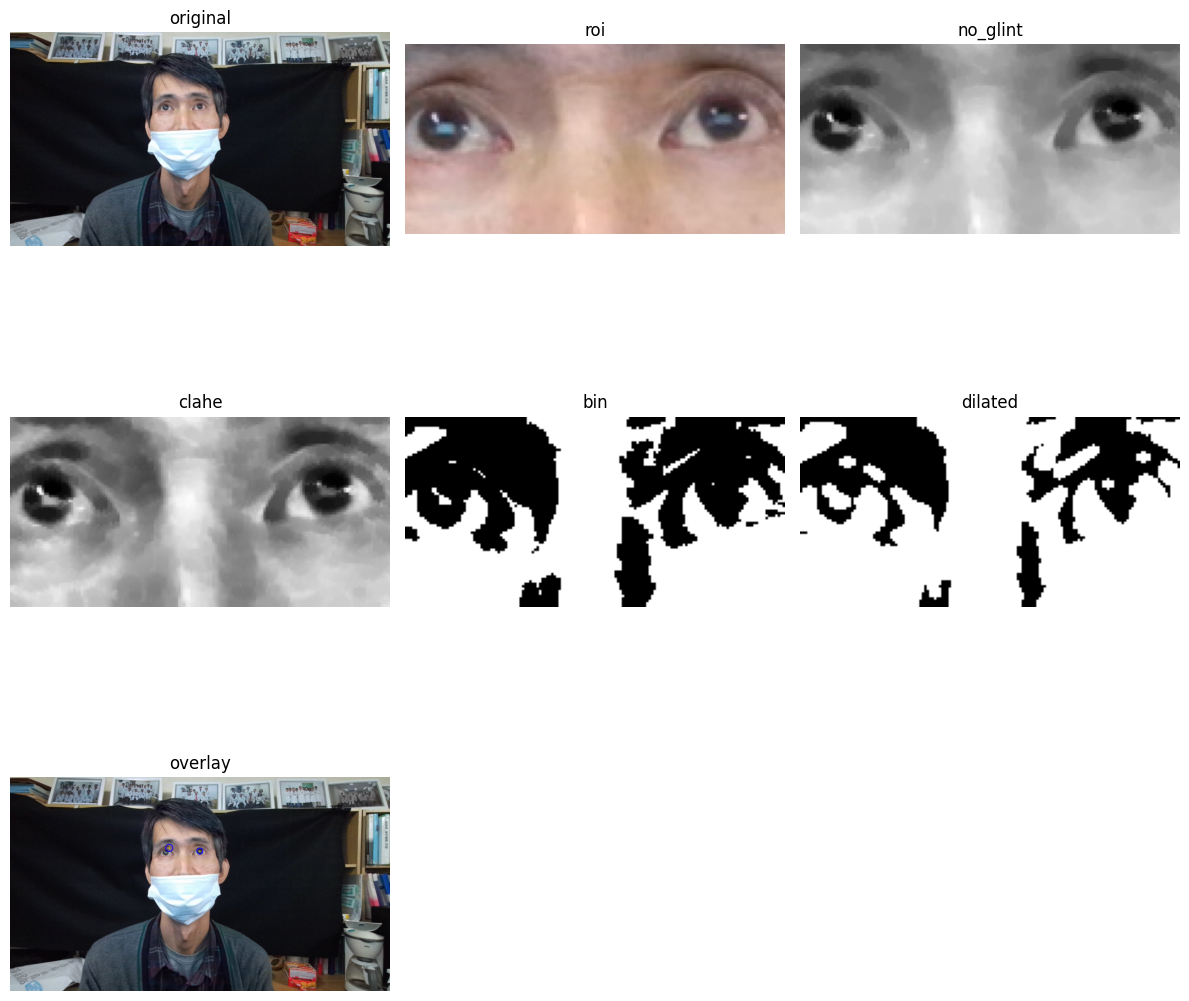

In [9]:
# 셀 5: 테스트

test_path = DATASET_ROOT / "s01" / "30" / "RGB" / "s01_30_RGB_F_0001.jpg"
print("test_path:", test_path)

dbg = process_single_debug_rgbir(test_path)

show_many(
    [
        dbg["original"], dbg["roi"], dbg["roi_no_glint"],
        dbg["roi_clahe"], dbg["roi_bin"], dbg["roi_dil"],
        dbg["overlay"]
    ],
    ["original", "roi", "no_glint", "clahe", "bin", "dilated", "overlay"],
    cols=3,
    size=4,
)




test_path: c:\Users\CONSOMMES\Downloads\DIP\dataset\s03\30\IR\s03_30_IR_F_0001.png


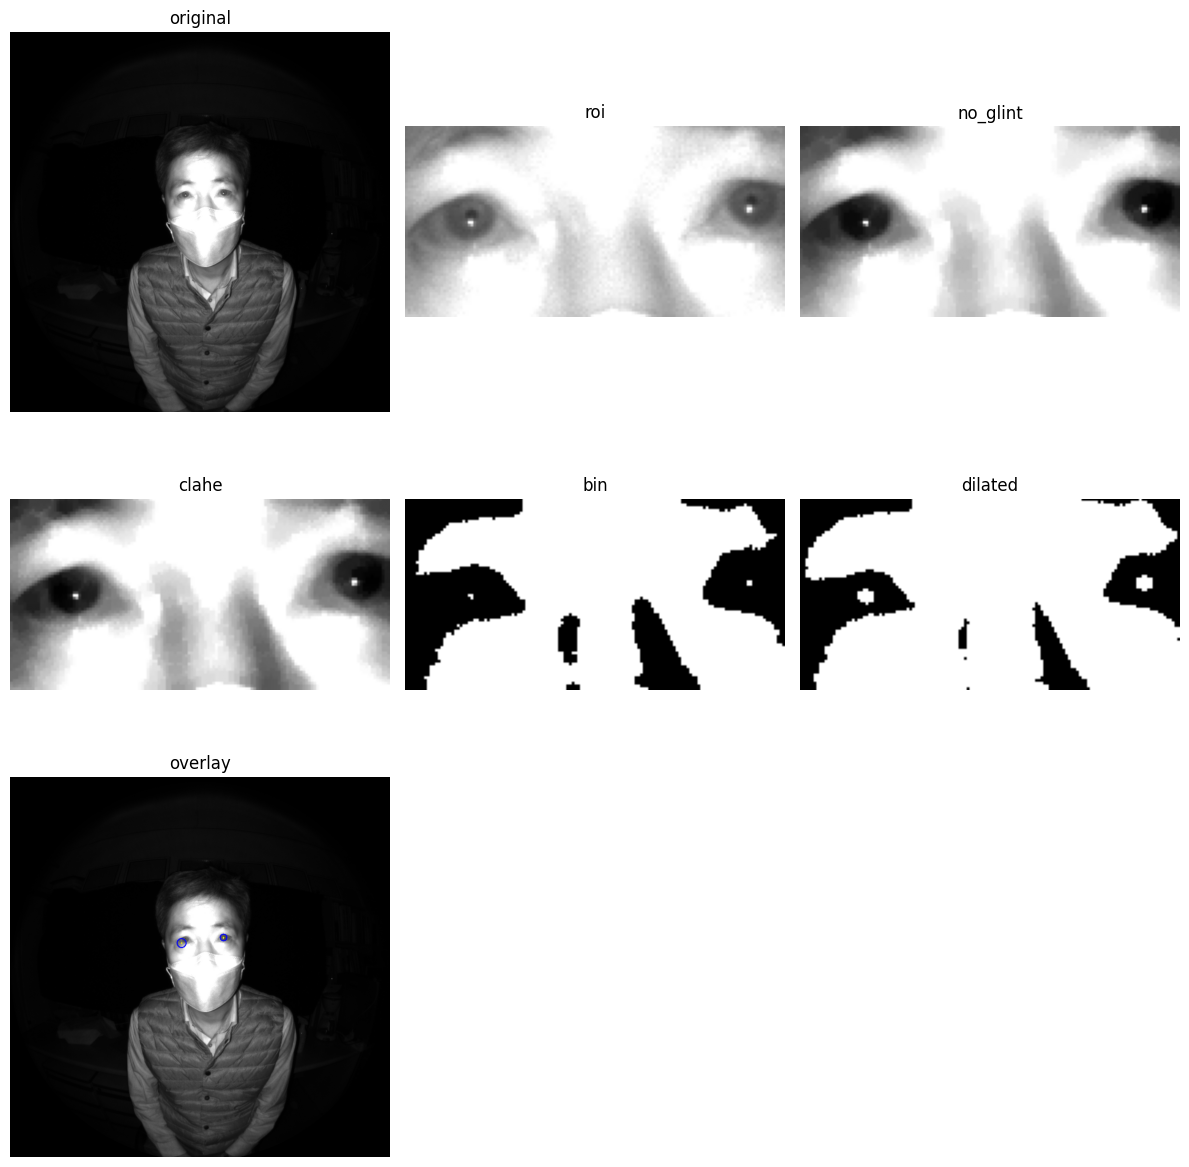

In [10]:
test_path = DATASET_ROOT / "s03" / "30" / "IR" / "s03_30_IR_F_0001.png"
print("test_path:", test_path)

dbg = process_single_debug_rgbir(test_path)

show_many(
    [
        dbg["original"], dbg["roi"], dbg["roi_no_glint"],
        dbg["roi_clahe"], dbg["roi_bin"], dbg["roi_dil"],
        dbg["overlay"]
    ],
    ["original", "roi", "no_glint", "clahe", "bin", "dilated", "overlay"],
    cols=3,
    size=4,
)
